In [1]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import os


import matplotlib as mpl
import scipy
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import xskillscore as xs
from scipy.stats import iqr

In [2]:
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/CMIP6_HB/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 't50':'_t50.nc', 'SST': '_tos.nc'}
models={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model == 'NESM3':
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
            except Exception as e:
                print(e)
                pass
        #now append data to model dict
        models[model] = mod

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_t50.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_tos.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/GODAS/GODAS_t50.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/SODA3.4.2/SODA3.4.2_t50.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/ORAS5/ORAS5_t50.nc'


In [3]:
#put the Obs into new dict
OBS={}
OBS['GODAS'] = models['GODAS']
OBS['ORAS5'] = models['ORAS5']
OBS['SODA3.4.2'] = models['SODA3.4.2']
OBS['ARGO'] = models['ARGO']

#delete obs from models dicts
del models['GODAS']
del models['ORAS5']
del models['SODA3.4.2']
del models['ARGO']

del models['not_full']


In [4]:
for i, model in enumerate(models.keys()):
    try:
        HB = models[model]
        t50=HB['t50']
        dTdt=HB['dTdt']
        #now turn all these variables into an array
        if i == 0:
            dtm = dTdt
            t50m = t50
        else:
            dtm = xr.concat([dtm, dTdt], dim = 'model')
            t50m = xr.concat([t50m, t50], dim = 'model')
    except:
        print('error', model)

In [5]:
#now make spatial plot of t50 bias
SSTB2 = t50m - OBS['ARGO']['t50']

In [6]:
SSTB2_pos = xr.where(SSTB2>0, 1,0)
SSTB2_neg = xr.where(SSTB2<0, 1,0)

SSTB_pos_ = SSTB2_pos.sum('model')
pos = xr.where(SSTB_pos_ >= 15, 1, 0)

SSTB_pos_ = SSTB2_neg.sum('model')
neg = xr.where(SSTB_pos_ >= 15, 1, 0)
sigbias = xr.where((pos+neg)==1, 1, np.nan)

/home/z5113258/anaconda3/lib/python3.8/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


Text(0.5, 0.98, 'Bias in depth averaged temperature down to 50m \n CMIP6 - ARGO')

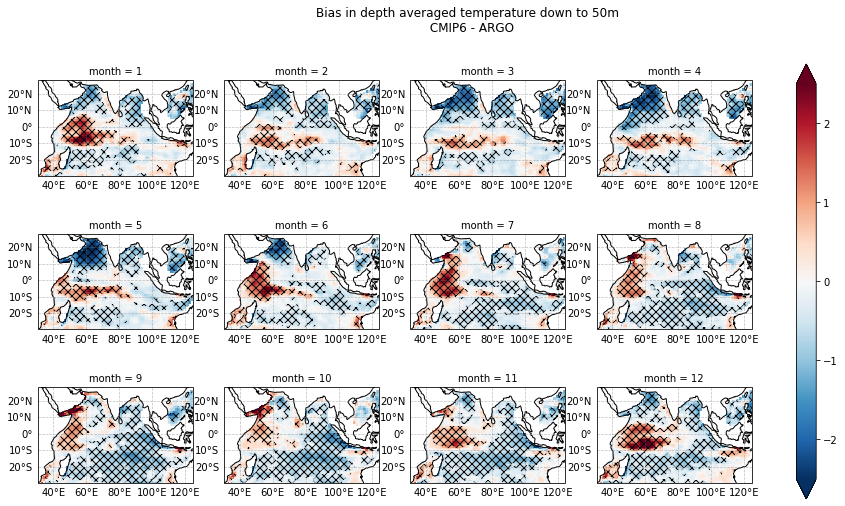

In [7]:
import cartopy.crs as ccrs
#plt.figure(figsize=(16,16))
fg = SSTB2.median('model').plot(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree()}, 
                              figsize=(16,8), vmin = -2.5, vmax = 2.5, cmap = 'RdBu_r')
for i, ax in enumerate(fg.axes.flat):
    ax.contourf(sigbias.lon, sigbias.lat, sigbias[i], [1,2], colors='none', hatches=['xxx',None])
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
fg.fig.suptitle('Bias in depth averaged temperature down to 50m \n CMIP6 - ARGO')

In [9]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0, 0.5, 'Temperature ($^\\circ$C)')

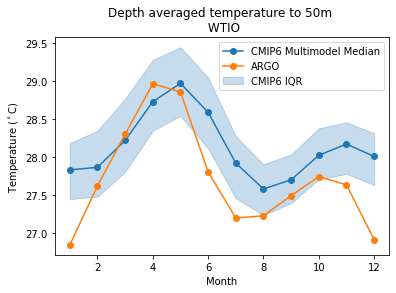

In [22]:
plt.plot(range(1,13), get_region((t50m.median('model')), -10, 10, 50, 70), linestyle='-', marker='o',  label = 'CMIP6 Multimodel Median')
plt.plot(range(1,13), get_region((OBS['ARGO']['t50']), -10, 10, 50, 70), linestyle='-', marker='o',  label = 'ARGO')
plt.fill_between(range(1,13), get_region(((t50m.quantile(0.25, 'model'))), -10, 10, 50, 70),
                      get_region(((t50m.quantile(0.75, 'model'))), -10, 10, 50, 70), 
                      alpha = 0.25, color='tab:blue', label = 'CMIP6 IQR')
plt.legend()
plt.title('Depth averaged temperature to 50m \n WTIO')
plt.xlabel('Month')
plt.ylabel('Temperature ($^\circ$C)')

/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0, 0.5, 'Temperature ($^\\circ$C)')

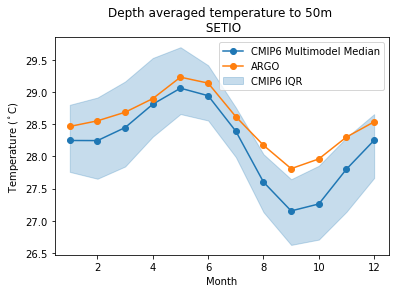

In [10]:
plt.plot(range(1,13), get_region((t50m.median('model')), -10, 0, 90, 110), linestyle='-', marker='o',  label = 'CMIP6 Multimodel Median')
plt.plot(range(1,13), get_region((OBS['ARGO']['t50']), -10, 0, 90, 110), linestyle='-', marker='o',  label = 'ARGO')
plt.fill_between(range(1,13), get_region(((t50m.quantile(0.25, 'model'))), -10, 0, 90, 110),
                      get_region(((t50m.quantile(0.75, 'model'))), -10, 0, 90, 110), 
                      alpha = 0.25, color='tab:blue', label = 'CMIP6 IQR')
plt.legend()
plt.title('Depth averaged temperature to 50m \n SETIO')
plt.xlabel('Month')
plt.ylabel('Temperature ($^\circ$C)')

In [2]:
#load in GODAS current data
u = xr.open_mfdataset("/home/z5113258/Documents/GODAS/remapbil_1/ucur/ucur.*.nc")
v = xr.open_mfdataset("/home/z5113258/Documents/GODAS/remapbil_1/vcur/vcur.*.nc")

In [3]:
u = u.sel(lat=slice(-30,30), lon = slice(40,120)).sel(level = slice(0,10))
v = v.sel(lat=slice(-30,30), lon = slice(40,120)).sel(level = slice(0,10))


In [4]:
u = u.ucur.mean('level')
v = v.vcur.mean('level')
u = u.groupby('time.month').mean('time')
v = v.groupby('time.month').mean('time')

In [5]:
t = np.meshgrid(u.lon, u.lat)

In [6]:
t[0].shape

(60, 80)

In [9]:
import matplotlib.patches as patches

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


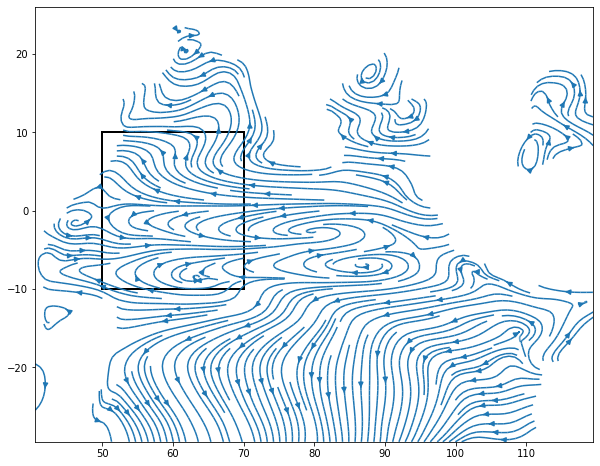

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


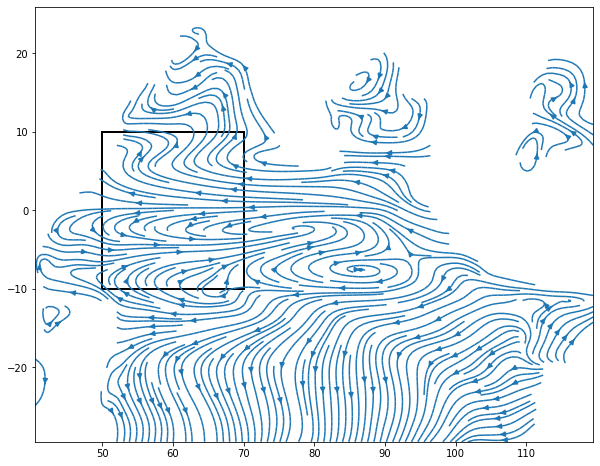

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


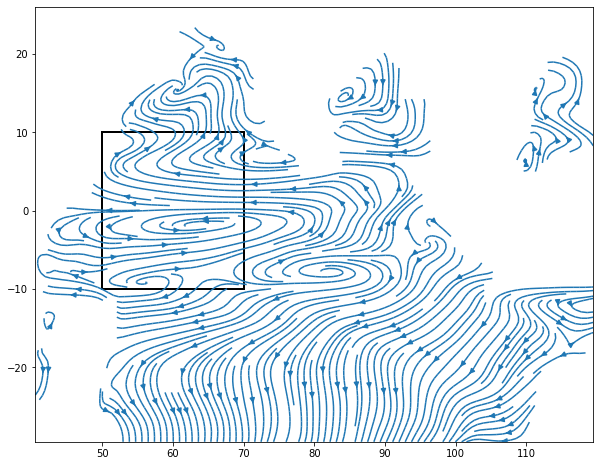

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


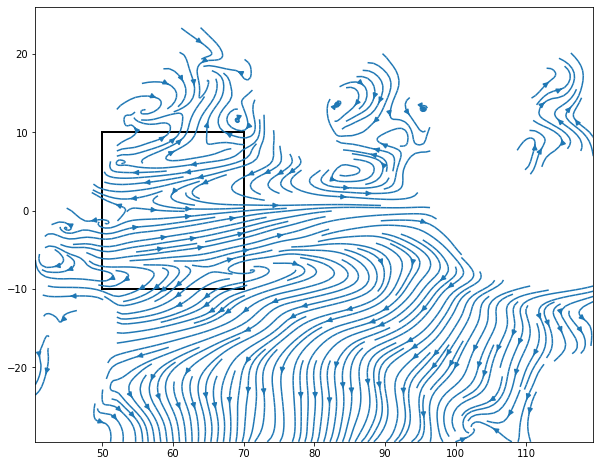

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


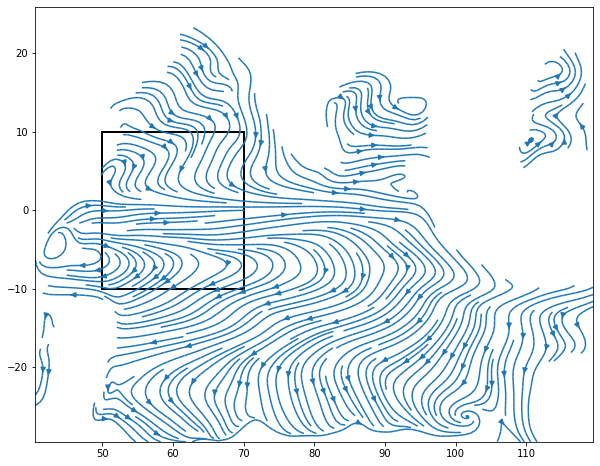

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


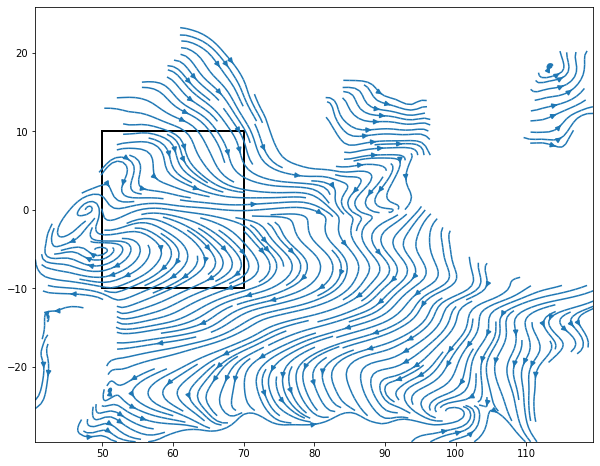

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


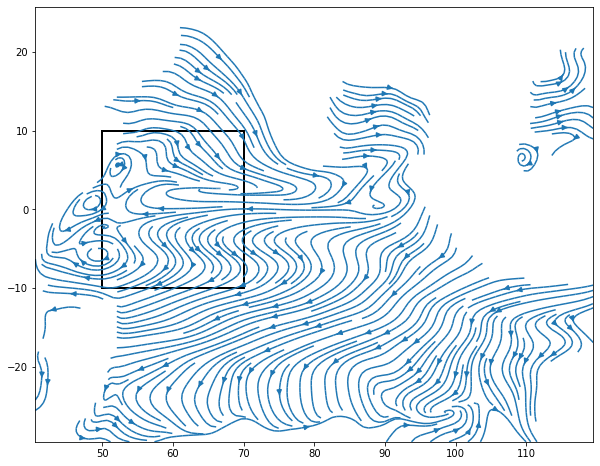

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


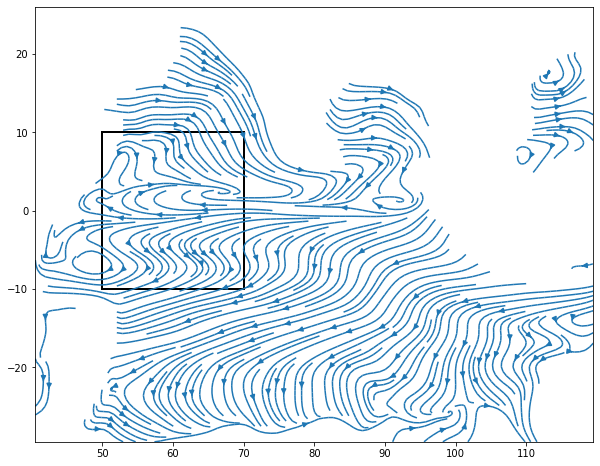

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


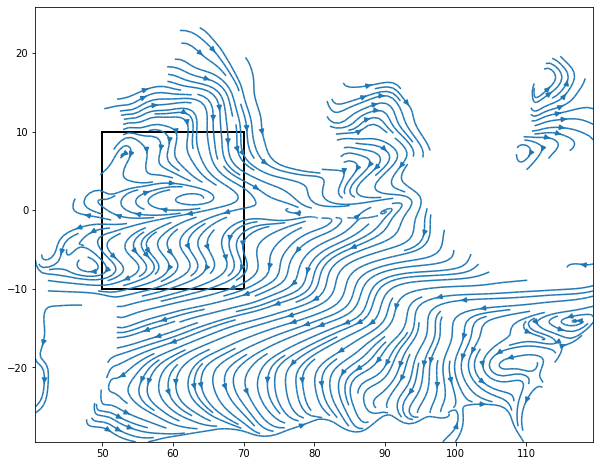

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


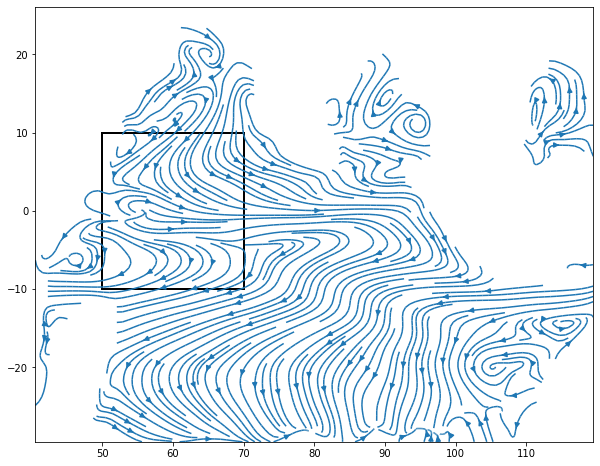

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


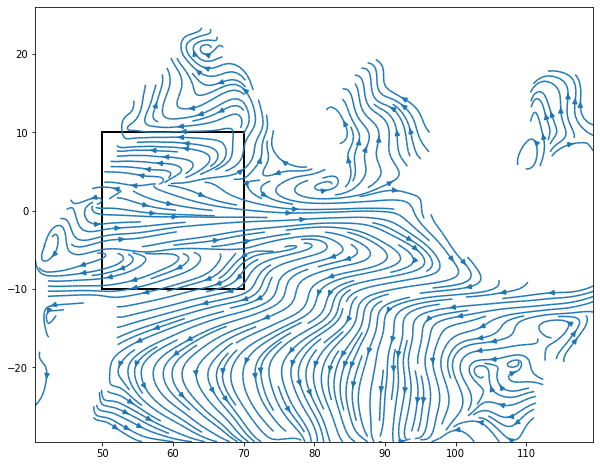

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


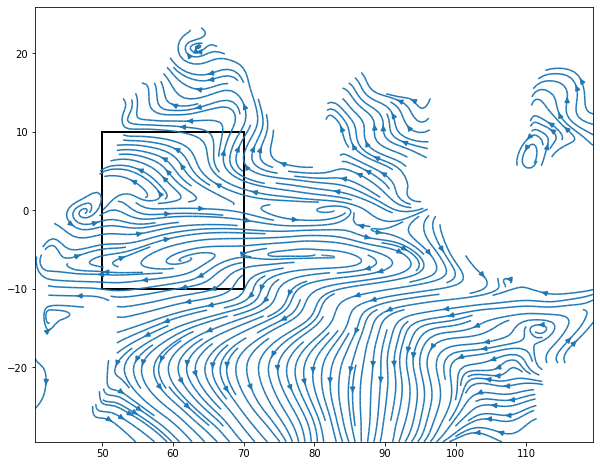

In [10]:
for i in range(0,12):
    fig, ax = plt.subplots(figsize=(10,8))
    #ax = plt.axes(projection=ccrs.PlateCarree())
    ax.streamplot(np.meshgrid(u.lon, u.lat)[0], np.meshgrid(u.lon, u.lat)[1], 
                   u[i], 
                   v[i],3)#, transform=ccrs.PlateCarree())
    rect = patches.Rectangle((50, -10), 20, 20, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    plt.show()
#ax.coastlines()